## Forecasting Production in the Automotive Industry

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
cols = ['quantity', 'price', 'interest', 'dipincome']
data = loadmat('./Data/jerryauto1.mat')
df = pd.DataFrame(data['DATA'], columns=cols)
full_df = np.log(df/df.shift(12))
full_df['quantity_1y_fwd'] = full_df['quantity'].shift(-12)
df = full_df.dropna().copy()

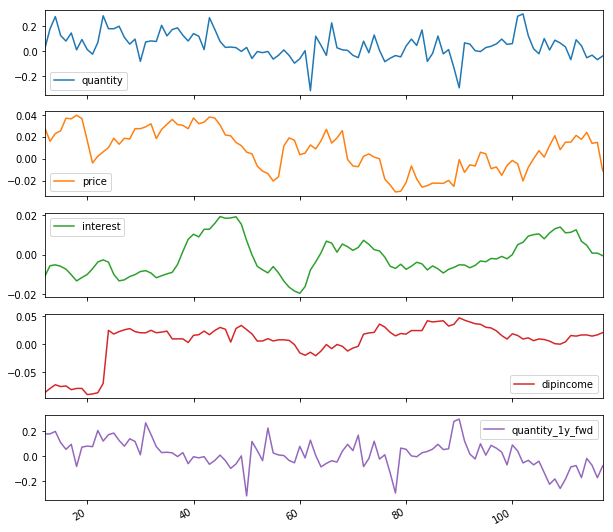

In [3]:
df.plot(subplots=True, figsize=(10,10));

### Summary of Data

In [4]:
df[cols].corr()

,quantity,price,interest,dipincome
quantity,1.000000,0.284652,0.124835,-0.170259
price,0.284652,1.000000,0.164644,-0.330384
interest,0.124835,0.164644,1.000000,0.214213
dipincome,-0.170259,-0.330384,0.214213,1.000000


In [5]:
df[cols].describe()[1:3]

,quantity,price,interest,dipincome
mean,0.044971,0.007705,-0.001190,0.005023
std,0.103215,0.018834,0.009187,0.033528


In [6]:
y = df[['quantity_1y_fwd']].values
x = df[cols].values
x = x[:100]
y = y[:100]

### Deep Learning with Keras

In [7]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import *
from sklearn.metrics import mean_squared_error, r2_score
import keras.backend as Kb

Using Theano backend.


In [8]:
def success_ratio(y_true, y_pred):
    #np.mean(np.sign(keras_out_sample.flatten())==np.sign(Y_test))
    return Kb.mean(Kb.equal(Kb.sign(y_true), Kb.sign(y_pred)))

In [ ]:
def r_coeff(y_true, y_pred):
    rss = Kb.sum(Kb.square(y_true-y_pred))
    sst = Kb.sum(Kb.square(y_true-Kb.mean(y_true)))
    return 1-(rss/(sst+Kb.epsilon()))

In [ ]:
Y = y
n = 60

X_train = x[:n,:]
Y_train = Y[:n,:]

X_test = x[n:n+12,:]
Y_test = Y[n:n+12,:]
print(X_train.shape)

(60, 4)


In [ ]:
model = Sequential()
model.add(Dense(4,
                input_dim=X_train.shape[1],
                activation='tanh',
               )
         )
model.add(Dropout(0.2))

#model.add(Dense(12))
#model.add(Dropout(0.2))

model.add(Dense(1))
#model.add(Activation('tanh'))
model.compile(loss='mse', optimizer='rmsprop', metrics=[success_ratio, r_coeff])

In [ ]:
history = model.fit(X_train, Y_train,
                    epochs=50000, 
                    batch_size=len(X_train), 
                    verbose=0,
                    validation_data=(X_test, Y_test), 
                    shuffle=True, 
                   )

In [ ]:
plt.figure(figsize=(15, 5)) 
plt.subplot(131)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

plt.subplot(132)
plt.plot(history.history['success_ratio'])
plt.plot(history.history['val_success_ratio']) 
plt.title('model success ratio') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

plt.subplot(133)
plt.plot(history.history['r_coeff'])
plt.plot(history.history['val_r_coeff']) 
plt.title('model R^2') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='best');

In [ ]:
# make predictions
keras_in_sample = model.predict(X_train)
keras_out_sample = model.predict(X_test)

In [ ]:
results = pd.DataFrame(y[:60+12,:], columns=['quantity_1yr_fwd'])
results['in_sample'] = np.nan
results['out_sample'] = np.nan
results.loc[:59, 'in_sample'] = keras_in_sample.flatten()
results.loc[60:60+12, 'out_sample'] = keras_out_sample.flatten()

In [ ]:
r2_in = r2_score(Y_train.flatten(), keras_in_sample.flatten())
r2_out = r2_score(Y_test.flatten(), keras_out_sample.flatten())
sr_in = np.mean(np.sign(keras_in_sample)==np.sign(Y_train.flatten()))
sr_out = np.mean(np.sign(keras_out_sample)==np.sign(Y_test.flatten()))
rmse_in = np.sqrt(mean_squared_error(Y_train.flatten(), keras_in_sample.flatten()))
rmse_out = np.sqrt(mean_squared_error(Y_test.flatten(), keras_out_sample.flatten()))

In [ ]:
title = 'In (R2: %.2f, SR: %.2f, RMSE: %.2f) -- Out (R2: %.2f, SR: %.2f, RMSE: %.2f)' \
        %(r2_in, sr_in, rmse_in, r2_out, sr_out, rmse_out)
results.plot(figsize=(15, 5), title=title);

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(Y_test.flatten(), label='model')
plt.plot(keras_out_sample.flatten(), label='predict')
plt.title('DL Out of Sample -- RMSE: %.2f, R2: %.2f, Sucess Ratio: %.2f ' % (rmse_out, r2_out, sr_out))
plt.legend(loc=0)
plt.show()